In [1]:
# 필요한 라이브러리 및 모듈을 가져옵니다.

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns


# 설정 값들을 정의합니다.
IMG_SIZE = 40, 40  # 이미지 크기
BATCH_SIZE = 32  # 배치 크기
SEED = 5  # 랜덤 시드
AUTO = tf.data.AUTOTUNE  # TensorFlow의 데이터 파이프라인을 최적화하기 위한 설정

In [2]:
# 주어진 경로에서 이미지 파일들의 전체 경로를 생성하는 함수를 정의합니다.
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path

# 각 클래스에 대한 이미지 경로를 생성합니다.
data_moon = create_images_list(os.getenv('HOME')+'/aiffel/jellyfish/new/Train/Moon_jellyfish')
data_barrel = create_images_list(os.getenv('HOME')+'/aiffel/jellyfish/new/Train/barrel_jellyfish')
data_blue = create_images_list(os.getenv('HOME')+'/aiffel/jellyfish/new/Train/blue_jellyfish')
data_compass = create_images_list(os.getenv('HOME')+'/aiffel/jellyfish/new/Train/compass_jellyfish')
data_lions_mane = create_images_list(os.getenv('HOME')+'/aiffel/jellyfish/new/Train/lions_mane_jellyfish')
data_mauve_stinger = create_images_list(os.getenv('HOME')+'/aiffel/jellyfish/new/Train/mauve_stinger_jellyfish')

# 클래스 레이블에 대한 룩업 테이블을 정의합니다.
jellyfish_classes = {0:'Moon', 1 : 'Barrel', 2 : 'Blue', 3 : 'Compass', 4 : 'Lion’s mane', 5: 'Mauve stinger'}

# 데이터프레임을 생성합니다.
data_df = pd.concat([pd.DataFrame({"img" : np.array(data_moon) , "label": 0 }),
                     pd.DataFrame({"img" : np.array(data_barrel) , "label": 1 }),
                     pd.DataFrame({"img" : np.array(data_blue) , "label": 2 }),
                     pd.DataFrame({"img" : np.array(data_compass) , "label": 3 }),
                     pd.DataFrame({"img" : np.array(data_lions_mane) , "label": 4 }),
                     pd.DataFrame({"img" : np.array(data_mauve_stinger) , "label": 5 }) ], ignore_index = True)

# 데이터를 섞고 인덱스를 재설정합니다.
data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)
data_df.head()

img  label
0  /aiffel/aiffel/jellyfish/new/Train/compass_jel...      3
1  /aiffel/aiffel/jellyfish/new/Train/blue_jellyf...      2
2  /aiffel/aiffel/jellyfish/new/Train/blue_jellyf...      2
3  /aiffel/aiffel/jellyfish/new/Train/mauve_sting...      5
4  /aiffel/aiffel/jellyfish/new/Train/compass_jel...      3

In [3]:
# 학습 및 검증용 데이터프레임과 테스트용 데이터프레임으로 나눕니다.
test_idx = data_df.shape[0] * 15 // 100  # 15 %를 테스트용으로 사용

train_df = data_df[test_idx:].reset_index(drop = True)
test_df = data_df[:test_idx].reset_index(drop = True)

# 데이터프레임 크기 출력
print("train_df (train and val) shape -> ", train_df.shape[0])
print("test_df shape -> ", test_df.shape[0])

train_df (train and val) shape ->  1542
test_df shape ->  271


In [4]:
# ConvMixer 블록을 정의하는 클래스를 생성합니다.
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

In [5]:
# 모델의 입력 레이어를 정의합니다.
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

# 모델의 초기 Conv2D 레이어를 정의합니다.
X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

# ConvMixer 블록을 여러 개 쌓아 모델을 구성합니다.
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)

# GlobalAveragePooling 레이어를 통해 공간 차원을 평균화합니다.
X = GlobalAveragePooling2D()(X)

# 출력 레이어를 정의합니다.
out = Dense(6, activation = 'softmax')(X)

# 전체 모델을 정의합니다.
model = Model(inputs = inp, outputs = out)
model.summary()

# 모델을 컴파일합니다.
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 256)       3328      
_________________________________________________________________
activation (Activation)      (None, 20, 20, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 256)       1024      
_________________________________________________________________
CONVMIXER_1 (ConvMixerBlock) (None, 20, 20, 256)       74496     
_________________________________________________________________
CONVMIXER_2 (ConvMixerBlock) (None, 20, 20, 256)       74496     
_________________________________________________________________
CONVMIXER_3 (ConvMixerBlock) (None, 20, 20, 256)       74496 

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# 이미지를 로드하여 배열로 변환하는 함수
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # 이미지를 [0, 1] 범위로 정규화
    return img_array

# 학습 데이터를 로드하고 전처리합니다.
X_train = np.array([load_and_preprocess_image(img_path) for img_path in train_df['img']])
y_train = train_df['label'].values

# 검증 데이터를 로드하고 전처리합니다.
X_val = np.array([load_and_preprocess_image(img_path) for img_path in test_df['img']])
y_val = test_df['label'].values

# 모델을 컴파일합니다.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

# 모델을 학습시킵니다.
history = model.fit(X_train, y_train,
                    epochs=10,  # 원하는 에폭 수로 설정
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val))

# 모델을 평가합니다.
test_loss, test_acc, test_top3_acc = model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Top-3 Accuracy: {test_top3_acc:.4f}")

Epoch 1/10
49/49 [==============================] - 10s 101ms/step - loss: 1.8158 - acc: 0.3191 - top_3_acc: 0.6958 - val_loss: 28.0486 - val_acc: 0.3247 - val_top_3_acc: 0.5793
Epoch 2/10
49/49 [==============================] - 4s 87ms/step - loss: 1.5412 - acc: 0.3949 - top_3_acc: 0.7685 - val_loss: 14.6451 - val_acc: 0.1771 - val_top_3_acc: 0.4576
Epoch 3/10
49/49 [==============================] - 4s 87ms/step - loss: 1.4145 - acc: 0.4540 - top_3_acc: 0.8100 - val_loss: 2.5890 - val_acc: 0.1587 - val_top_3_acc: 0.5498
Epoch 4/10
49/49 [==============================] - 4s 88ms/step - loss: 1.3200 - acc: 0.4747 - top_3_acc: 0.8385 - val_loss: 2.2114 - val_acc: 0.1439 - val_top_3_acc: 0.5203
Epoch 5/10
49/49 [==============================] - 4s 88ms/step - loss: 1.2593 - acc: 0.5000 - top_3_acc: 0.8593 - val_loss: 2.0443 - val_acc: 0.2066 - val_top_3_acc: 0.6162
Epoch 6/10
49/49 [==============================] - 4s 88ms/step - loss: 1.1982 - acc: 0.5454 - top_3_acc: 0.8774 - val_l

## val_acc: 0.4576, Test Accuracy: 0.4576

## 데이터 증강 추가

In [7]:

# 이미지를 로드하여 배열로 변환하는 함수
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # 이미지를 [0, 1] 범위로 정규화
    return img_array

# 데이터 증강을 위한 ImageDataGenerator 설정
datagen = ImageDataGenerator(
    rotation_range=20,      # 이미지 회전 각도 범위 (도)
    width_shift_range=0.2,  # 가로 방향으로 이미지 이동 비율
    height_shift_range=0.2, # 세로 방향으로 이미지 이동 비율
    shear_range=0.2,        # 전단 변형 강도
    zoom_range=0.2,         # 이미지 확대/축소 비율
    horizontal_flip=True,   # 수평 방향으로 뒤집기
    fill_mode='nearest'     # 이미지를 변형할 때 생기는 빈 픽셀을 채우는 방법
)

# 학습 데이터를 로드하고 전처리합니다.
X_train = np.array([load_and_preprocess_image(img_path) for img_path in train_df['img']])
y_train = train_df['label'].values

# 검증 데이터를 로드하고 전처리합니다.
X_val = np.array([load_and_preprocess_image(img_path) for img_path in test_df['img']])
y_val = test_df['label'].values

# 데이터 증강을 적용하고 배치 생성을 위한 generator 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# 모델을 컴파일합니다.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

# 모델을 학습시킵니다.
history = model.fit(train_datagen,
                    epochs=10,  # 원하는 에폭 수로 설정
                    steps_per_epoch=len(X_train) // BATCH_SIZE,  # 한 에폭당 스텝 수
                    validation_data=(X_val, y_val))

# 모델을 평가합니다.
test_loss, test_acc, test_top3_acc = model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Top-3 Accuracy: {test_top3_acc:.4f}")

Epoch 1/10
48/48 [==============================] - 8s 98ms/step - loss: 1.2500 - acc: 0.5291 - top_3_acc: 0.8497 - val_loss: 7.5192 - val_acc: 0.2583 - val_top_3_acc: 0.6347
Epoch 2/10
48/48 [==============================] - 4s 88ms/step - loss: 1.1042 - acc: 0.5974 - top_3_acc: 0.8954 - val_loss: 8.7866 - val_acc: 0.1882 - val_top_3_acc: 0.6273
Epoch 3/10
48/48 [==============================] - 4s 88ms/step - loss: 1.0891 - acc: 0.6060 - top_3_acc: 0.8993 - val_loss: 3.6888 - val_acc: 0.2915 - val_top_3_acc: 0.7159
Epoch 4/10
48/48 [==============================] - 4s 89ms/step - loss: 1.0386 - acc: 0.6152 - top_3_acc: 0.9106 - val_loss: 1.5859 - val_acc: 0.5055 - val_top_3_acc: 0.8487
Epoch 5/10
48/48 [==============================] - 4s 89ms/step - loss: 0.9740 - acc: 0.6430 - top_3_acc: 0.9146 - val_loss: 3.4212 - val_acc: 0.3727 - val_top_3_acc: 0.6863
Epoch 6/10
48/48 [==============================] - 4s 89ms/step - loss: 0.9308 - acc: 0.6709 - top_3_acc: 0.9113 - val_loss:

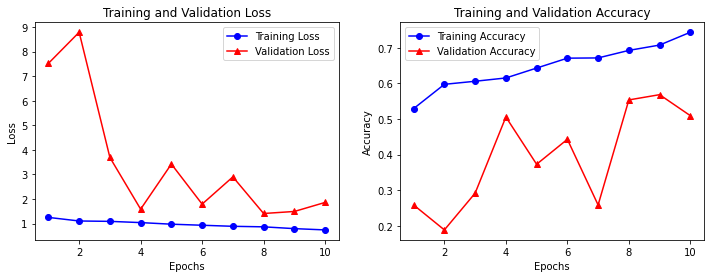

In [8]:

# 모델을 학습시킨 후에 주석 아래의 코드를 실행하여 결과를 시각화합니다.

# 훈련 손실과 정확도
train_loss = history.history['loss']
train_acc = history.history['acc']

# 검증 손실과 정확도
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# 에폭 수
epochs = range(1, len(train_loss) + 1)

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프 표시
plt.show()

## val_acc: 0.5092, Test Accuracy: 0.5092
## 에폭 100으로 설정, 조기종료 추가, 히트맵 추가


Epoch 1/100
48/48 [==============================] - 4s 88ms/step - loss: 0.7330 - acc: 0.7305 - top_3_acc: 0.9523 - val_loss: 2.0058 - val_acc: 0.4391 - val_top_3_acc: 0.8339
Epoch 2/100
48/48 [==============================] - 4s 87ms/step - loss: 0.7451 - acc: 0.7265 - top_3_acc: 0.9583 - val_loss: 1.3686 - val_acc: 0.6089 - val_top_3_acc: 0.8967
Epoch 3/100
48/48 [==============================] - 4s 87ms/step - loss: 0.6387 - acc: 0.7795 - top_3_acc: 0.9642 - val_loss: 1.0868 - val_acc: 0.6568 - val_top_3_acc: 0.9188
Epoch 4/100
48/48 [==============================] - 4s 88ms/step - loss: 0.6173 - acc: 0.7781 - top_3_acc: 0.9695 - val_loss: 1.7722 - val_acc: 0.5683 - val_top_3_acc: 0.9114
Epoch 5/100
48/48 [==============================] - 4s 88ms/step - loss: 0.6120 - acc: 0.7815 - top_3_acc: 0.9702 - val_loss: 2.7117 - val_acc: 0.4391 - val_top_3_acc: 0.8598
Epoch 6/100
48/48 [==============================] - 4s 88ms/step - loss: 0.5761 - acc: 0.7993 - top_3_acc: 0.9755 - val

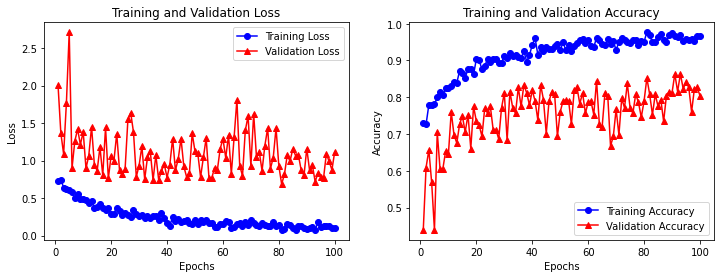

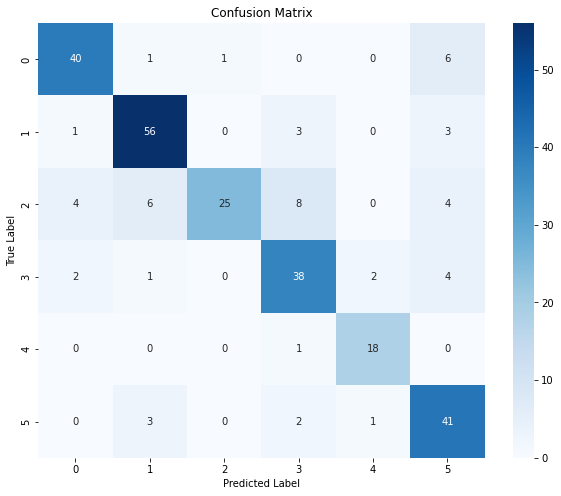

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.multiclass import unique_labels
# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# 모델을 학습시킵니다.
history = model.fit(train_datagen,
                    epochs=100,  # 원하는 에폭 수로 설정
                    steps_per_epoch=len(X_train) // BATCH_SIZE,  # 한 에폭당 스텝 수
                    validation_data=(X_val, y_val))

# 모델을 평가합니다.
test_loss, test_acc, test_top3_acc = model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Top-3 Accuracy: {test_top3_acc:.4f}")

# 모델을 학습시킨 후에 주석 아래의 코드를 실행하여 결과를 시각화합니다.

# 훈련 손실과 정확도
train_loss = history.history['loss']
train_acc = history.history['acc']

# 검증 손실과 정확도
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# 에폭 수
epochs = range(1, len(train_loss) + 1)


# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프 표시
plt.show()

# 모델 예측을 기반으로 한 히트맵 생성
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix 생성
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=unique_labels(y_val), yticklabels=unique_labels(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## val_acc: 0.8044, Test Accuracy: 0.8044

## 학습속도도 빠르고 정확도가 높았다.

Image: NR0FOK401J88.jpg, Predicted Class: 0


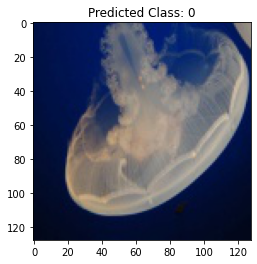

Image: 23.jpg, Predicted Class: 0


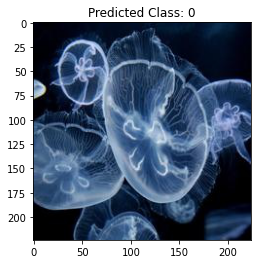

Image: ZC2WGQ1980EJ.jpg, Predicted Class: 0


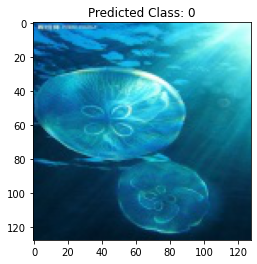

Image: ZQMLKNLR8V0E.jpg, Predicted Class: 3


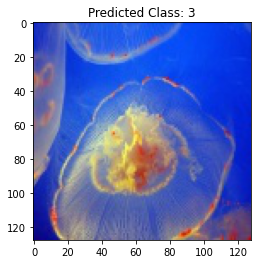

Image: UNGNOXB2Y5WJ.jpg, Predicted Class: 0


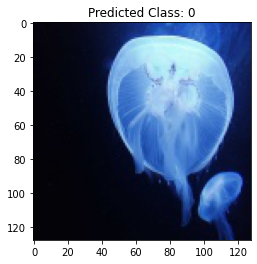

Image: 3VKS5Z1KYMGZ.jpg, Predicted Class: 0


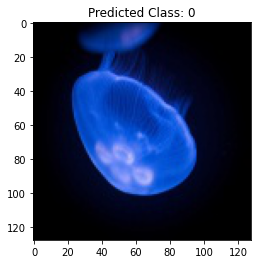

Image: 14LJK7YIH5SJ.jpg, Predicted Class: 0


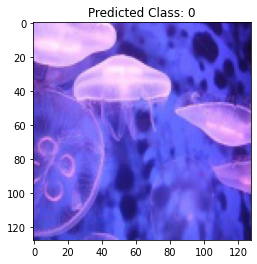

Image: Moon_jellyfish_285.jpg, Predicted Class: 0


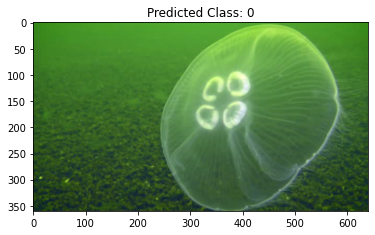

Image: Moon_jellyfish_22.jpg, Predicted Class: 0


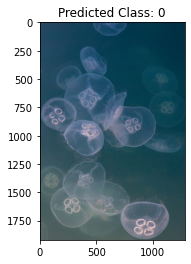

Image: ZPFGNNHNKL7O.jpg, Predicted Class: 0


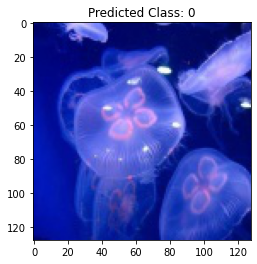

Image: Moon_jellyfish_137.jpg, Predicted Class: 2


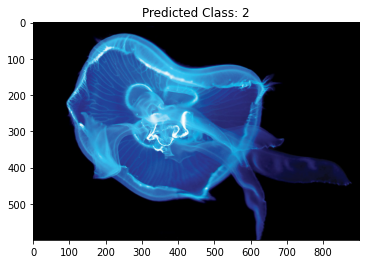

Image: YNENAHHI4NWW.jpg, Predicted Class: 0


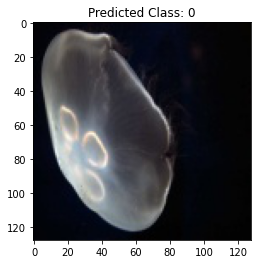

Image: 48.jpg, Predicted Class: 0


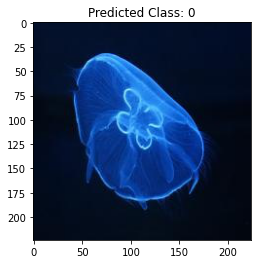

Image: KZ7A4XECZNMA.jpg, Predicted Class: 1


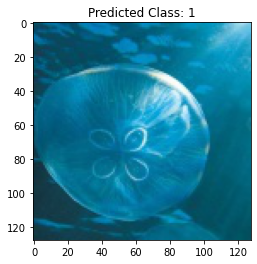

Image: Moon_jellyfish_115.jpg, Predicted Class: 0


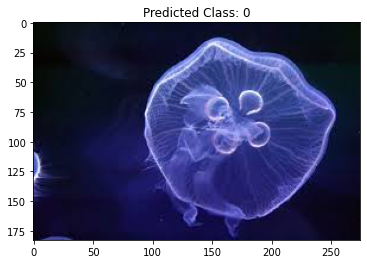

Image: Moon_jellyfish_253.jpg, Predicted Class: 0


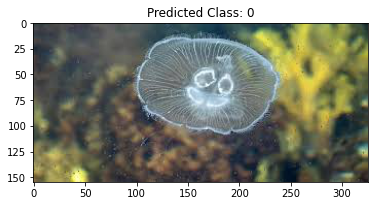

Image: NYOWA1OFYC1M.jpg, Predicted Class: 0


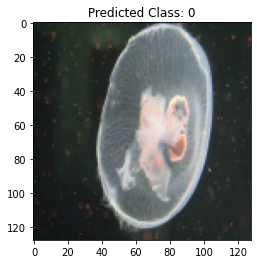

Image: 69WQGDKKKTCR.jpg, Predicted Class: 0


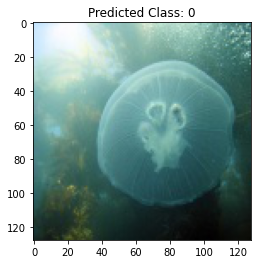

Image: OS98VCB7C8GS.jpg, Predicted Class: 0


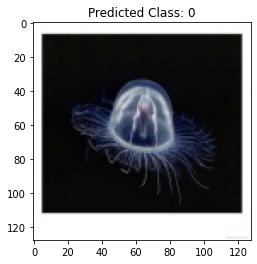

Image: L1EYIR2AJTLF.jpg, Predicted Class: 0


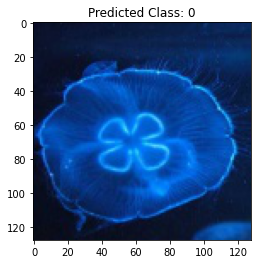

Image: Z6ARCITJQNT8.jpg, Predicted Class: 0


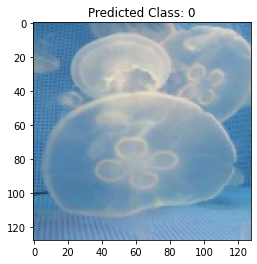

Image: 6S3TM79G4UMF.jpg, Predicted Class: 0


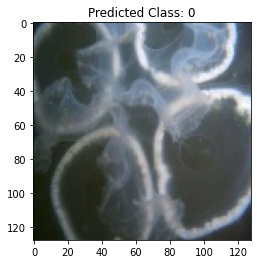

Image: HFA6HN5IR794.jpg, Predicted Class: 0


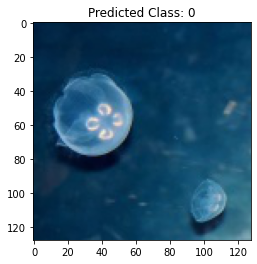

Image: Q6D87N1H69Y7.jpg, Predicted Class: 3


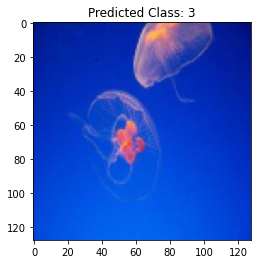

Image: GLRG7A9C3KI4.jpg, Predicted Class: 3


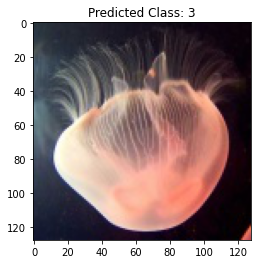

Image: Moon_jellyfish_305.jpg, Predicted Class: 5


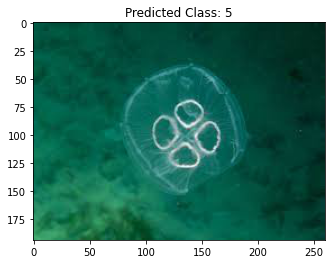

Image: 6J7L40U0ST8W.jpg, Predicted Class: 0


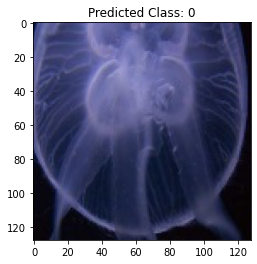

Image: NHEN5FA94F2A.jpg, Predicted Class: 0


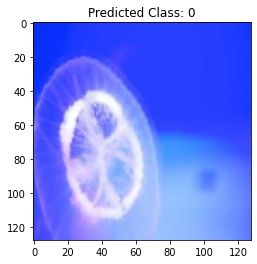

Image: ZVPOG5SGT9WC.jpg, Predicted Class: 0


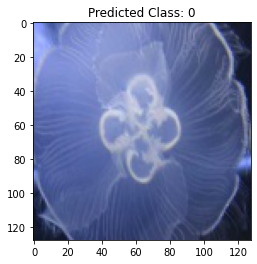

Image: CDUKQ6B0MGKU.jpg, Predicted Class: 0


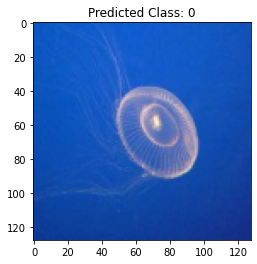

Image: 11.jpg, Predicted Class: 0


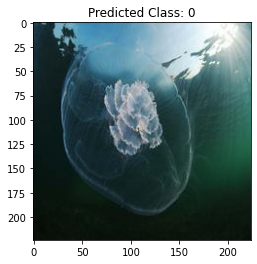

Image: blue_jellyfish_137.jpg, Predicted Class: 0


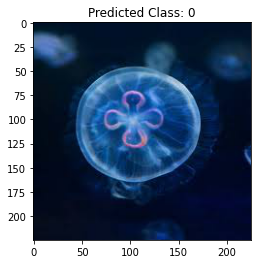

Image: MNX6UHRXD3A1.jpg, Predicted Class: 0


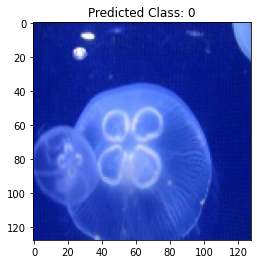

Image: O9CSS4XDJXUZ.jpg, Predicted Class: 0


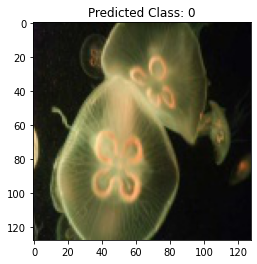

Image: Moon_jellyfish_10.jpg, Predicted Class: 0


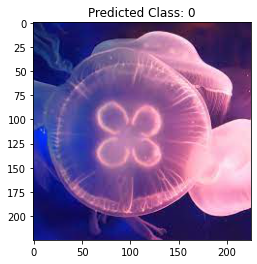

Image: Moon_jellyfish_261.jpg, Predicted Class: 0


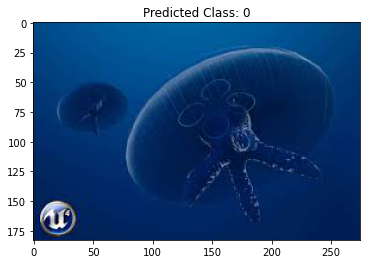

Image: HNAQXKBZLP2K.jpg, Predicted Class: 0


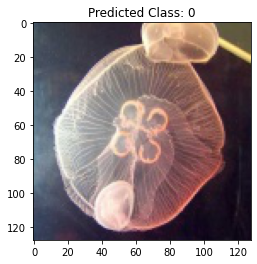

Image: Moon_jellyfish_239.jpg, Predicted Class: 0


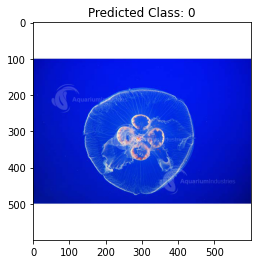

Image: 85MHM9M3WZC9.jpg, Predicted Class: 0


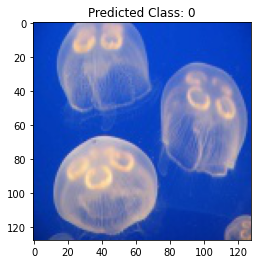

Image: 19.jpg, Predicted Class: 0


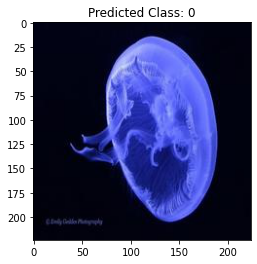

Image: Moon_jellyfish_18.jpg, Predicted Class: 0


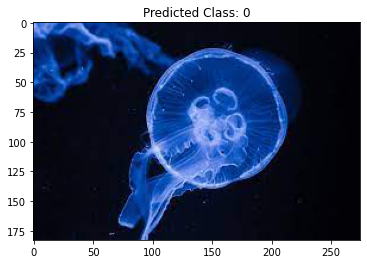

Image: VW9VZEUGZ2DB.jpg, Predicted Class: 0


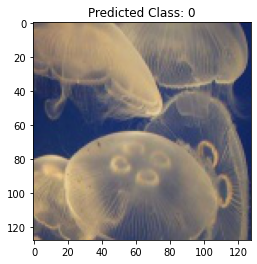

Image: Moon_jellyfish_307.jpg, Predicted Class: 3


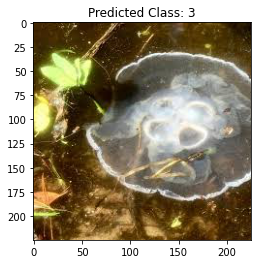

Image: APEC4B53AA8N.jpg, Predicted Class: 0


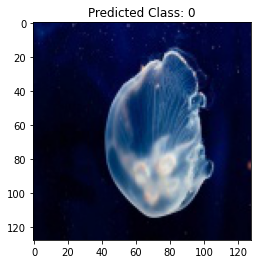

Image: N6FTTT03X08Z.jpg, Predicted Class: 0


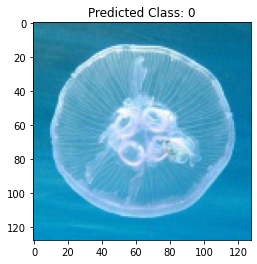

Image: 1238G5KX1SY7.jpg, Predicted Class: 0


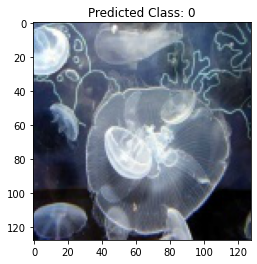

Image: Moon_jellyfish_364.jpg, Predicted Class: 0


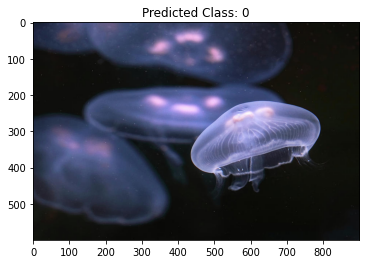

Image: B9MUC3KMV488.jpg, Predicted Class: 0


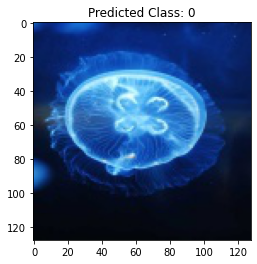

Image: 33.jpg, Predicted Class: 0


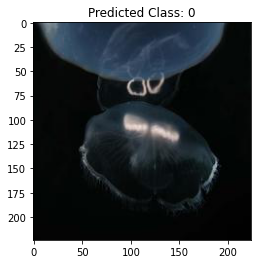

Image: YIT41VRMIXPX.jpg, Predicted Class: 0


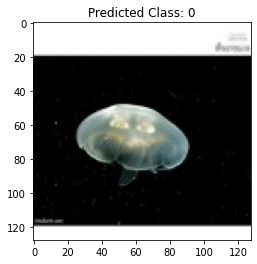

Image: 8YTX3P0T4RSO.jpg, Predicted Class: 0


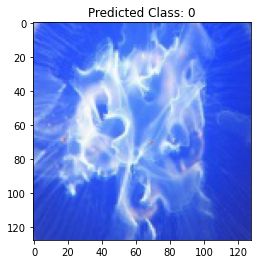

Image: 8Z3HPRNW81HY.jpg, Predicted Class: 0


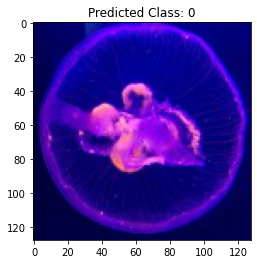

Image: Moon_jellyfish_30.jpg, Predicted Class: 0


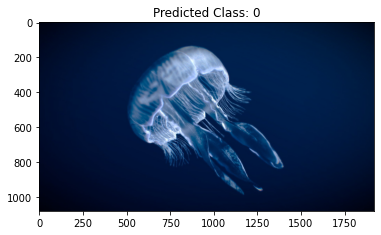

Image: Moon_jellyfish_114.jpg, Predicted Class: 0


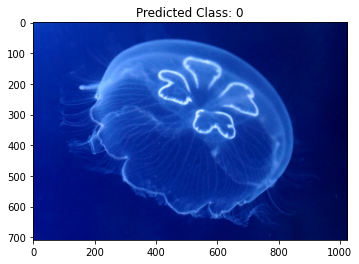

Image: Moon_jellyfish_6.jpg, Predicted Class: 0


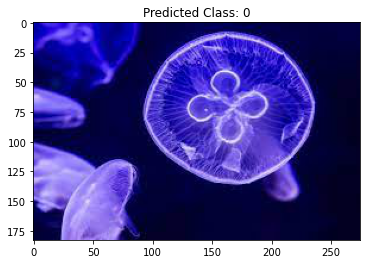

In [10]:
# 테스트 데이터 검증_Moon_jellyfish

# 새로운 이미지가 있는 폴더 경로
folder_path = os.getenv('HOME')+'/aiffel/jellyfish/Train_Test_Valid/test/Moon_jellyfish'

# 폴더 내의 모든 이미지 파일에 대한 예측 수행
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # 이미지 파일의 전체 경로 생성
        image_path = os.path.join(folder_path, filename)
        
        # 이미지를 전처리하고 모델에 입력하기
        new_image = load_and_preprocess_image(image_path)
        new_image = np.expand_dims(new_image, axis=0)  # 모델에 입력하기 위해 차원을 확장
        prediction = model.predict(new_image)

        # 예측 결과 출력
        predicted_class = np.argmax(prediction)
        print(f"Image: {filename}, Predicted Class: {predicted_class}")

        # 예측 결과 및 이미지 시각화 (선택 사항)
        plt.imshow(load_img(image_path))
        plt.title(f"Predicted Class: {predicted_class}")
        plt.show()



In [15]:
# 폴더 경로
base_folder_path = os.getenv('HOME') + '/aiffel/jellyfish/Train_Test_Valid/test'

# 모든 서브폴더 탐색
for folder_name, subfolders, filenames in os.walk(base_folder_path):
    for filename in filenames:
        if filename.endswith((".jpg", ".jpeg", ".png")):
            # 이미지 파일의 전체 경로 생성
            image_path = os.path.join(folder_name, filename)

            # 이미지를 전처리하고 모델에 입력하기
            new_image = load_and_preprocess_image(image_path)
            new_image = np.expand_dims(new_image, axis=0)  # 모델에 입력하기 위해 차원을 확장
            prediction = model.predict(new_image)

            # 예측 결과 출력
            predicted_class = np.argmax(prediction)
            print(f"Image: {image_path}, Predicted Class: {predicted_class}")

#             # 예측 결과 및 이미지 시각화 (선택 사항)
#             plt.imshow(load_img(image_path))
#             plt.title(f"Predicted Class: {predicted_class}")
#             plt.show()

Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/PKYZ57IIORY2.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/AZPO7NW7VHVO.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/pelagia8_IMG_00003.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/L9Q1FDHZ9SXY.jpg, Predicted Class: 0
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/P2BKS4PI2MZI.jpg, Predicted Class: 4
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/A7UFIC255RIS.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/48.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/34.jpg, Predicted Class: 3
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/test/mauve_stinger_jellyfish/14.jpg, Predicte

## 테스트 데이터 검증 결과 정확도 68.4%

In [12]:
# 폴더 경로
base_folder_path = os.getenv('HOME') + '/aiffel/jellyfish/Train_Test_Valid/valid'

# 모든 서브폴더 탐색
for folder_name, subfolders, filenames in os.walk(base_folder_path):
    for filename in filenames:
        if filename.endswith((".jpg", ".jpeg", ".png")):
            # 이미지 파일의 전체 경로 생성
            image_path = os.path.join(folder_name, filename)

            # 이미지를 전처리하고 모델에 입력하기
            new_image = load_and_preprocess_image(image_path)
            new_image = np.expand_dims(new_image, axis=0)  # 모델에 입력하기 위해 차원을 확장
            prediction = model.predict(new_image)

            # 예측 결과 출력
            predicted_class = np.argmax(prediction)
            print(f"Image: {image_path}, Predicted Class: {predicted_class}")

Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/60.jpg, Predicted Class: 0
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/27.jpg, Predicted Class: 1
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/67.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/70.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/19.jpg, Predicted Class: 3
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/38.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/10.jpg, Predicted Class: 5
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/60.jpg, Predicted Class: 2
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/20.jpg, Predicted Class: 2
Image: /aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jell

## 검증데이터 정확도 62.1%